# Prophet Application for Water Demand Forecase

## 1. Load Required Libraries

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import folium
from folium.plugins import MarkerCluster
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import r2_score as R2
from sklearn.metrics import mean_squared_error as MSE
from scipy.stats import skew
import os
import sys
from glob import glob 
from calendar import day_abbr, month_abbr, mdays
from prophet import Prophet
import holidays
sys.path.append('code/')
import utils

import warnings
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", FutureWarning, )
%matplotlib inline

np.random.seed(42)

## 2. Load Data

### 2.1 Load Past Predictor (Independent) Variables

In [2]:
folder_name = '특광역시'
CITY_NAME_Kor = '서울특별시'
CITY_NAME_Eng = 'Seoul'
predictor_raw = pd.read_excel("../data/영향분석/시군별_영향인자(독립변수)/특광역시/특별시 및 광역시 종합.xlsx", sheet_name=CITY_NAME_Kor)
col_name = predictor_raw.iloc[2].values
predictor_raw1 = predictor_raw.iloc[3:, :29] # header 및 일단위자료 삭제
predictor_raw1.columns = col_name[:29]
predictor_raw1_len = predictor_raw1['연도'].isna().argmax()
predictor_raw1 = predictor_raw1[:predictor_raw1_len]
predictor_raw1.index = pd.to_datetime(predictor_raw1['연도'][:predictor_raw1_len].astype(str) + '-' + predictor_raw1['월'][:predictor_raw1_len].astype(str))
predictor_raw1.rename_axis(columns='', inplace=True)
predictor_raw1.drop(columns=['연도', '월'], inplace=True)
predictor_raw1.index.name = "date"
predictor_raw1 = predictor_raw1.astype(float)
predictor_raw1.columns = ['Total_Population', 'Households', 'Population_per_Households', 'Male_Population', 'Female_Population', 'Male_Female_Ratio', 'Population_aging_Ratio', 
                'Power_usage', 'Num_of_Business', 'Business_above_100', 'complex_area', 'annual_household_income',
                'High_School_Graduate_num', 'High_School_Graduate_ratio', 'personal_expense', 'benefits_vs_personal_expense', 'employment_ratio', 'employment_insurance_ratio', 'vulnerable_class', 'vulnerable_class_ratio',
                'Temp', 'Rainfall', 'Humidity', 'Solar_radiation', 'Ground_Temp', 'Wind', 'Pressure']
predictor_f = predictor_raw1.loc["2017-01-01":"2021-12-01"]
predictor_f.head()

,Total_Population,Households,Population_per_Households,Male_Population,Female_Population,Male_Female_Ratio,Population_aging_Ratio,Power_usage,Num_of_Business,Business_above_100,...,employment_insurance_ratio,vulnerable_class,vulnerable_class_ratio,Temp,Rainfall,Humidity,Solar_radiation,Ground_Temp,Wind,Pressure
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,9930478.0,4192985.0,2.368355,4875745.0,5054733.0,0.964590,13.1,4.416889e+09,476774.0,5179.0,...,0.407796,59247.0,0.014130,-1.8,14.9,55.0,209.0,-0.7,2.3,1014.7
2017-02-01,9931412.0,4200761.0,2.364194,4874839.0,5056573.0,0.964060,13.2,4.127699e+09,468721.0,5148.0,...,0.411018,59275.0,0.014111,-0.2,11.1,54.0,210.0,1.0,2.4,1012.6
2017-03-01,9926968.0,4202888.0,2.361940,4871560.0,5055408.0,0.963633,13.3,3.582654e+09,470722.0,5287.0,...,0.411362,59372.0,0.014126,6.3,7.9,48.0,255.2,8.1,2.4,1009.0
2017-04-01,9922745.0,4203957.0,2.360335,4868367.0,5054378.0,0.963198,13.3,3.591552e+09,472938.0,5329.0,...,0.415280,59516.0,0.014157,13.9,61.6,52.0,259.7,16.9,2.6,1002.6
2017-05-01,9919016.0,4207393.0,2.357521,4865778.0,5053238.0,0.962903,13.4,3.419987e+09,473675.0,5323.0,...,0.416158,59551.0,0.014154,19.5,16.1,52.0,301.5,25.0,2.4,1002.0


### 2.2 Load Past Response (Dependent) Variable: 용수공급량 ("월별 공급량/월별 일수"를 통해 m3/day으로 평균하여 표현)

In [3]:
import pandas as pd

water_supply_raw = pd.read_excel("../data/영향분석/가뭄DB 시군별 일평균 공급량(17-21).xlsx", header=1)
water_supply_raw["ds"] = water_supply_raw["지자체명"].values
water_supply_raw = water_supply_raw.iloc[1:, 1:]
water_supply_raw.head()

,합계,서울특별시,부산광역시,대구광역시,인천광역시,광주광역시,대전광역시,울산광역시,세종특별자치시,수원시,...,남해군,하동군,산청군,함양군,거창군,합천군,제주도,제주시,서귀포시,ds
1,1.893060e+07,3.007799e+06,1.060027e+06,869115.838710,9.928449e+05,466281.193548,532618.387097,549092.419355,71077.354839,347215.806452,...,21971.612903,10735.903226,7341.612903,12337.838710,16646.129032,9709.000000,401742.677419,275900.838710,125841.838710,2017-01
2,1.908267e+07,3.029100e+06,1.059022e+06,891206.285714,1.003291e+06,464250.678571,539851.071429,547782.428571,73424.964286,347747.178571,...,21999.250000,10549.821429,7683.321429,12368.214286,16420.035714,9123.857143,405419.214286,278513.857143,126905.357143,2017-02
3,1.907035e+07,3.064747e+06,1.068665e+06,910011.096774,9.926171e+05,471358.709677,541762.903226,548019.548387,74140.935484,352081.645161,...,21405.387097,10864.387097,7250.193548,12010.774194,16759.387097,8800.516129,406935.387097,279909.193548,127026.193548,2017-03
4,1.928037e+07,3.117700e+06,1.060834e+06,927455.500000,9.969582e+05,482653.300000,555743.000000,562844.266667,73835.433333,354228.166667,...,21007.100000,11176.466667,7889.500000,11571.933333,16835.366667,8692.266667,411843.700000,282280.200000,129563.500000,2017-04
5,1.969785e+07,3.189195e+06,1.072468e+06,943258.354839,1.008504e+06,493875.935484,571588.387097,563131.774194,81844.967742,360011.838710,...,22450.193548,11437.387097,8211.064516,11833.290323,17557.064516,9358.258065,417198.677419,285814.064516,131384.612903,2017-05


### 2.3 Load Future Predictor (Independent) Variables

In [4]:
future_factor = pd.read_excel("../data/수요예측/시군별_영향인자_장래예측/특광역시.xlsx", sheet_name=CITY_NAME_Kor)
future_factor_1 = future_factor.iloc[3:19, :8] # header 및 일단위자료 삭제
future_factor_1.columns = future_factor.iloc[2, :8] # set column names
future_factor_1.index = pd.to_datetime(future_factor_1["연도"], format='%Y')
future_factor_1 = future_factor_1.resample('MS').ffill()
future_factor_1.index.name = "date"
future_factors1 = future_factor_1[future_factor_1.columns[1:]]
#future_factors1.columns = ['총인구수', '세대수', '세대당 인구', '남자 인구수', '여자 인구수', '남여 비율', '고령화비율']
future_factors1.columns = ['Total_Population', 'Households', 'Population_per_Households', 'Male_Population', 'Female_Population', 
                           'Male_Female_Ratio', 'Population_aging_Ratio']
future_factors1 = future_factors1.astype(float)
future_factors1

,Total_Population,Households,Population_per_Households,Male_Population,Female_Population,Male_Female_Ratio,Population_aging_Ratio
date,,,,,,,
2022-01-01,9487764.0,3873473.0,2.449420,4591453.0,4896311.0,0.937737,0.170804
2022-02-01,9487764.0,3873473.0,2.449420,4591453.0,4896311.0,0.937737,0.170804
2022-03-01,9487764.0,3873473.0,2.449420,4591453.0,4896311.0,0.937737,0.170804
2022-04-01,9487764.0,3873473.0,2.449420,4591453.0,4896311.0,0.937737,0.170804
2022-05-01,9487764.0,3873473.0,2.449420,4591453.0,4896311.0,0.937737,0.170804
...,...,...,...,...,...,...,...
2036-09-01,8912133.0,3872077.0,2.301641,4268533.0,4643600.0,0.919229,0.292904
2036-10-01,8912133.0,3872077.0,2.301641,4268533.0,4643600.0,0.919229,0.292904
2036-11-01,8912133.0,3872077.0,2.301641,4268533.0,4643600.0,0.919229,0.292904


### 2.4 Load Future Response (Dependent) Variable: 용수공급량 ("월별 공급량/월별 일수"를 통해 m3/day으로 평균하여 표현)

In [5]:
future_factor_3 = future_factor.iloc[135:316, 22:28] # header 및 일단위자료 삭제
future_factor_3.columns = future_factor.iloc[2, 22:28] # set column names
future_factor_3.index = pd.to_datetime(future_factor_1.index)
future_factor_3.index.name = "date"
future_factors2 = future_factor_3[['월합강수량(mm)', '습도\n평균상대습도(%)', '평균온도(°C)']]
#future_factors2.columns = ['월강수량', '습도', '기온']
future_factors2.columns = ['Rainfall', 'Humidity', 'Temp']
future_factors2 = future_factors2.astype(float)
future_factors2

,Rainfall,Humidity,Temp
date,,,
2022-01-01,32.493489,0.600252,-0.948870
2022-02-01,0.000306,0.512353,2.762175
2022-03-01,60.479186,0.573968,6.777495
2022-04-01,98.223170,0.582993,14.580462
2022-05-01,135.633470,0.708381,20.175607
...,...,...,...
2036-09-01,165.259234,0.701292,22.478360
2036-10-01,40.334394,0.685275,17.569732
2036-11-01,155.607310,0.701412,11.717292


### 2.5 Merge Every Dataset

In [6]:
future_factors1_1 = future_factors1.loc["2022-01-01":"2035-01-01"]
future_factors2_1 = future_factors2.loc["2022-01-01":"2035-01-01"]
future_factor = pd.concat([future_factors1_1, future_factors2_1], axis=1)
predictor_f["y"] = water_supply_raw[CITY_NAME_Kor].values
total_data_df1 = pd.concat([predictor_f, future_factor], axis=0)

total_data_df = total_data_df1[['y', 'Total_Population', 'Households', 'Population_per_Households', 'Male_Population', 'Female_Population', 
                               'Male_Female_Ratio', 'Population_aging_Ratio', 'Rainfall', 'Humidity', 'Temp']]
total_data_df

/tmp/ipykernel_5738/984949930.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictor_f["y"] = water_supply_raw[CITY_NAME_Kor].values


,y,Total_Population,Households,Population_per_Households,Male_Population,Female_Population,Male_Female_Ratio,Population_aging_Ratio,Rainfall,Humidity,Temp
date,,,,,,,,,,,
2017-01-01,3.007799e+06,9930478.0,4192985.0,2.368355,4875745.0,5054733.0,0.964590,13.100000,14.900000,55.000000,-1.800000
2017-02-01,3.029100e+06,9931412.0,4200761.0,2.364194,4874839.0,5056573.0,0.964060,13.200000,11.100000,54.000000,-0.200000
2017-03-01,3.064747e+06,9926968.0,4202888.0,2.361940,4871560.0,5055408.0,0.963633,13.300000,7.900000,48.000000,6.300000
2017-04-01,3.117700e+06,9922745.0,4203957.0,2.360335,4868367.0,5054378.0,0.963198,13.300000,61.600000,52.000000,13.900000
2017-05-01,3.189195e+06,9919016.0,4207393.0,2.357521,4865778.0,5053238.0,0.962903,13.400000,16.100000,52.000000,19.500000
...,...,...,...,...,...,...,...,...,...,...,...
2034-09-01,NaN,8994658.0,3888453.0,2.313171,4314660.0,4679998.0,0.921936,0.274925,17.473418,0.639263,23.841022
2034-10-01,NaN,8994658.0,3888453.0,2.313171,4314660.0,4679998.0,0.921936,0.274925,21.209567,0.560021,16.753755
2034-11-01,NaN,8994658.0,3888453.0,2.313171,4314660.0,4679998.0,0.921936,0.274925,19.714946,0.561118,11.048479


## 3. Application of Prophet

### 3.1 Univariate Analysis using past water supply

#### 3.1.1 Prepare Training and Test data

In [7]:
data_train = total_data_df.loc["2017-01-01":"2020-12-01"][['y']]
data_train['ds'] = data_train.index
#data_train.index = range(0, len(data_train))
data_test = total_data_df.loc["2021-01-01":"2021-12-01"][['y']]
data_test['ds'] = data_test.index

#### 3.1.2 Training and Testing using Multiplicative Decomposition

08:29:50 - cmdstanpy - INFO - CmdStan installation /opt/conda/envs/water_forecast/lib/python3.9/site-packages/prophet/stan_model/cmdstan-2.26.1 missing makefile, cannot get version.
08:29:50 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
08:29:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

08:29:58 - cmdstanpy - INFO - CmdStan done processing.
08:29:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in '/project/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in '/project/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
08:29:58 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 150 iterations at max treedepth (100.0%)
	Chain 2 had 1


MAE=200386.09684312122 R2=-2.9218978911817506 RMSE=205664.29609264212 Correlation=0.9000735621224606


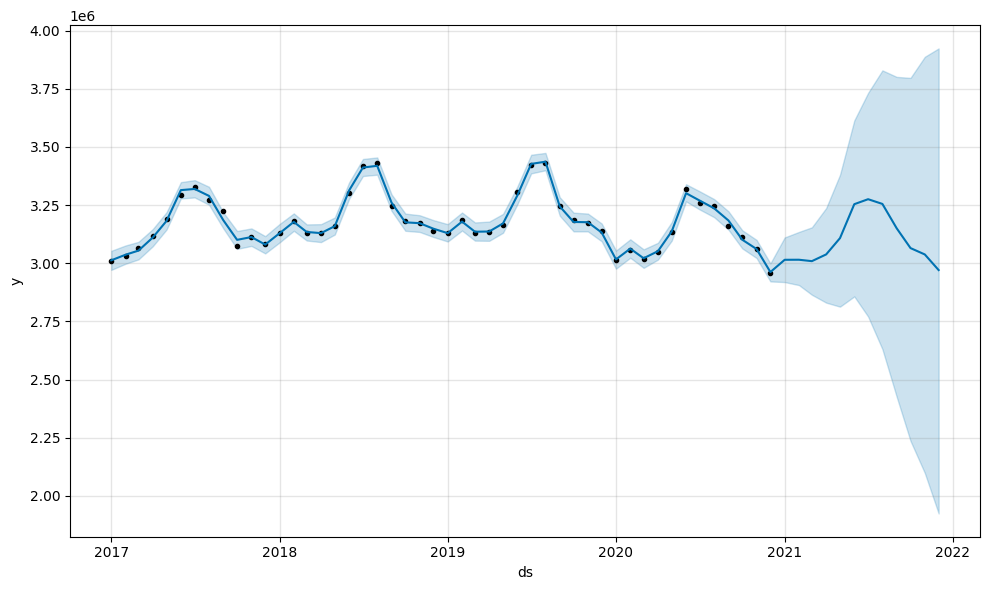

In [137]:
m1 = Prophet(mcmc_samples=300, changepoint_prior_scale=0.9, seasonality_mode='multiplicative', yearly_seasonality=10)
m1.fit(data_train)
future1_1 = m1.make_future_dataframe(periods=len(data_test), freq='MS')
verification1 = m1.predict(future1_1)
MAE_value = MAE(verification1['yhat'][-12:], data_test['y'])
R2_value = R2(verification1['yhat'][-12:], data_test['y'])
RMSE_value = MSE(verification1['yhat'][-12:], data_test['y'])**0.5
Correlation = np.corrcoef(verification1['yhat'][-12:], data_test['y'])[0,1]
print("MAE="+ str(MAE_value), "R2="+ str(R2_value), "RMSE="+ str(RMSE_value), "Correlation="+ str(Correlation))
verif_fig = m1.plot(verification1)

#### 3.1.3 Training and Testing using Multiplicative Decomposition

In [9]:
verif_d1 = utils.make_verif(verification1, data_train, data_test)
verif_d1.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat,y
ds,,,,,,,,,,,,,,,,,
2021-08-01,2021-08-01,3.124153e+06,2.664493e+06,3.901900e+06,2.533498e+06,3.706178e+06,0.050700,0.042145,0.059189,0.050700,0.042145,0.059189,0.0,0.0,0.0,3.282547e+06,3.399201e+06
2021-09-01,2021-09-01,3.125066e+06,2.453212e+06,3.882262e+06,2.418652e+06,3.826137e+06,0.016865,0.007186,0.027133,0.016865,0.007186,0.027133,0.0,0.0,0.0,3.177771e+06,3.300085e+06
2021-10-01,2021-10-01,3.125949e+06,2.250167e+06,3.869315e+06,2.281203e+06,3.937693e+06,-0.010747,-0.022162,0.001830,-0.010747,-0.022162,0.001830,0.0,0.0,0.0,3.092355e+06,3.254104e+06
2021-11-01,2021-11-01,3.126863e+06,2.082510e+06,3.970686e+06,2.129029e+06,4.050042e+06,-0.020835,-0.034227,-0.007343,-0.020835,-0.034227,-0.007343,0.0,0.0,0.0,3.061714e+06,3.251766e+06
2021-12-01,2021-12-01,3.127746e+06,1.903933e+06,4.031586e+06,1.993102e+06,4.195205e+06,-0.040101,-0.050945,-0.028085,-0.040101,-0.050945,-0.028085,0.0,0.0,0.0,3.002320e+06,3.212158e+06


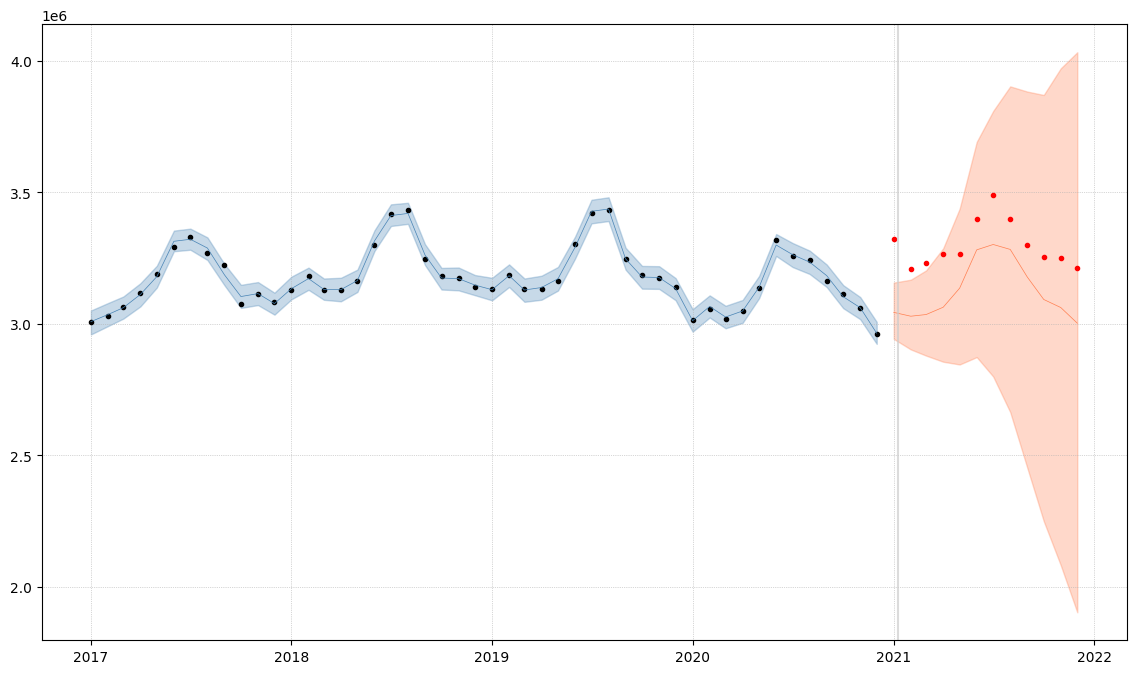

In [10]:
f =  utils.plot_verif(verif_d1)

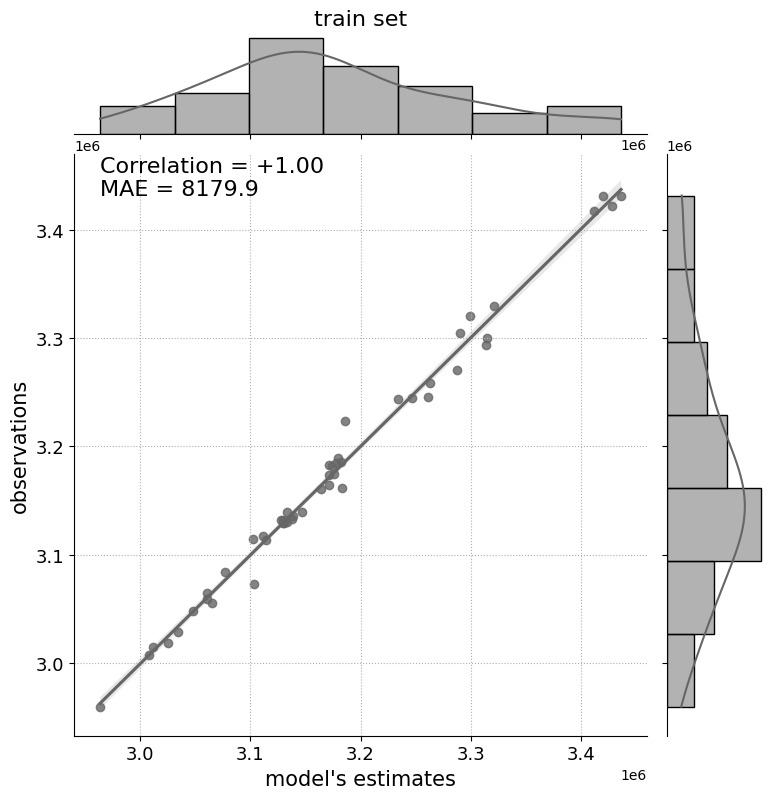

In [11]:
utils.plot_joint_plot(verif_d1.loc[:'2020-12-01',:], title='train set', fname='train_set_joint_plot_climate')

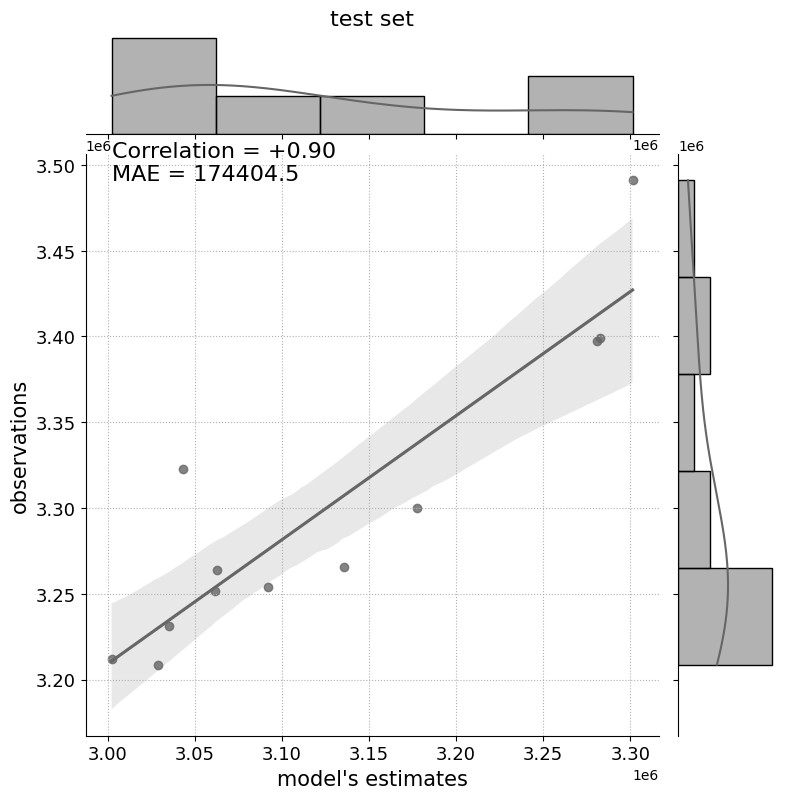

In [12]:
utils.plot_joint_plot(verif_d1.loc['2021-01-01':,:], title='test set', fname='test_set_joint_plot_no_climate')

In [13]:
residuals1 = verif_d1.loc['2021-01-01':,'yhat'] - verif_d1.loc['2021-01-01':,'y']

/tmp/ipykernel_5738/2076104489.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residuals1, ax=ax, color='0.4')


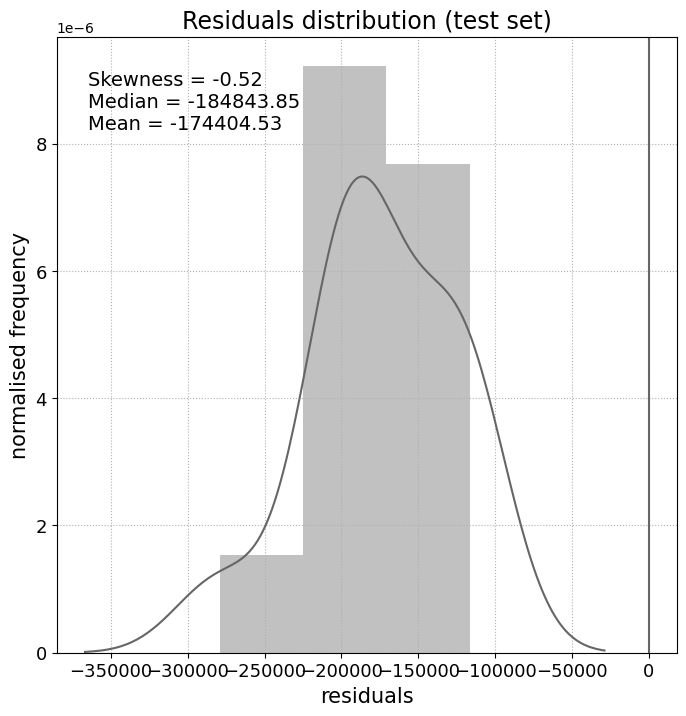

In [14]:
f, ax = plt.subplots(figsize=(8,8))
sns.distplot(residuals1, ax=ax, color='0.4')
ax.grid(ls=':')
ax.set_xlabel('residuals', fontsize=15)
ax.set_ylabel("normalised frequency", fontsize=15)
ax.grid(ls=':')

[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()];

ax.axvline(0, color='0.4')
ax.set_title('Residuals distribution (test set)', fontsize=17)

ax.text(0.05, 0.85, "Skewness = {:+4.2f}\nMedian = {:+4.2f}\nMean = {:+4.2f}".\
        format(skew(residuals1), residuals1.median(), residuals1.mean()), \
        fontsize=14, transform=ax.transAxes)

for ext in ['png','jpeg','pdf']: 
    f.savefig(f'../figures/paper/residuals_distribution_test_set_climate.{ext}', dpi=200)

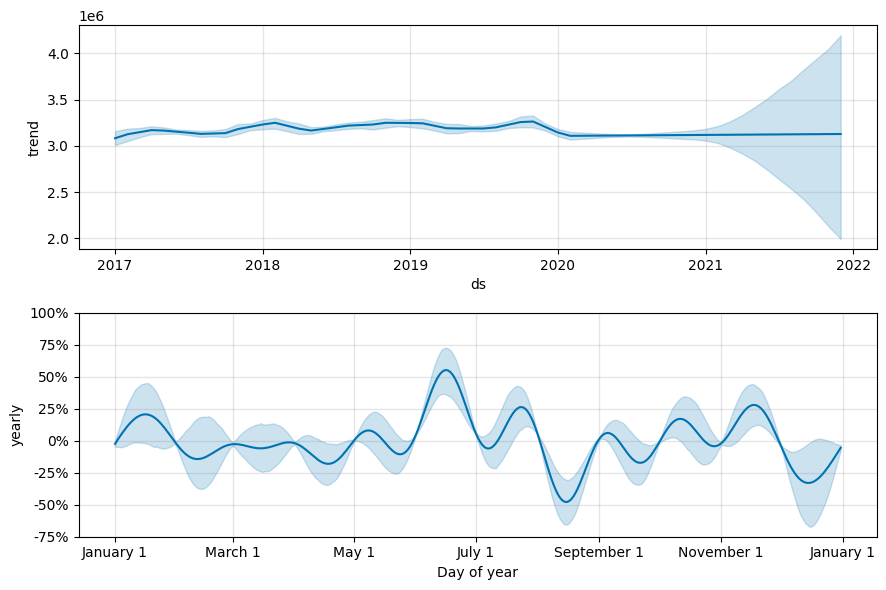

In [15]:
f = m1.plot_components(verification1)

In [16]:
data_future1 = total_data_df.loc["2021-01-01":"2035-01-01"][['y']]
data_future1['ds'] = data_future1.index

(2800000.0, 3600000.0)

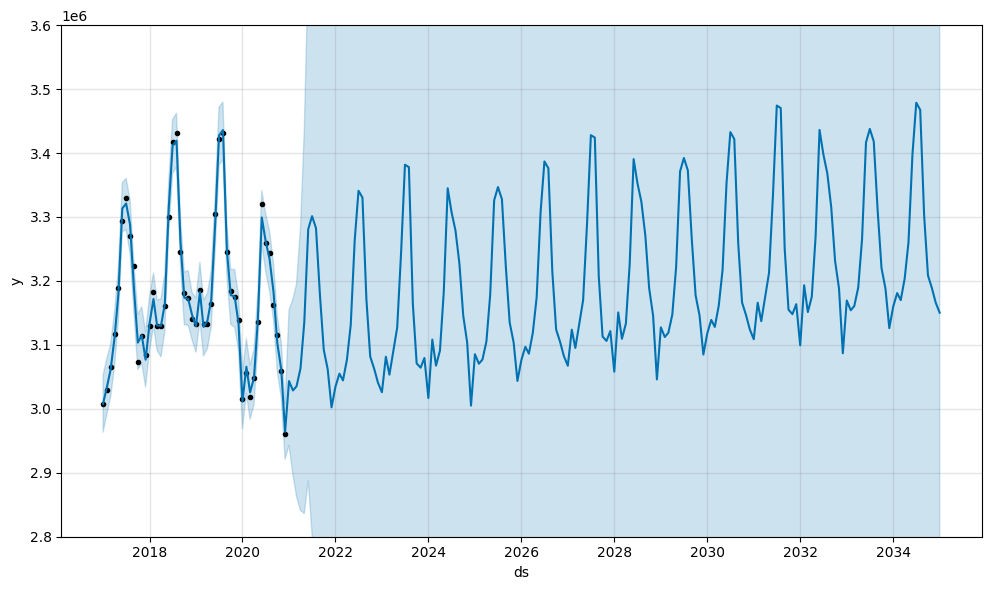

In [19]:
future1_2 = m1.make_future_dataframe(periods=len(data_future1), freq='MS')
forecast1 = m1.predict(future1_2)
forecast_fig_1 = m1.plot(forecast1)
ax = forecast_fig_1.gca()
ax.set_ylim(2800000, 3600000)

## Additive

05:48:39 - cmdstanpy - INFO - CmdStan installation /opt/conda/envs/water_forecast/lib/python3.9/site-packages/prophet/stan_model/cmdstan-2.26.1 missing makefile, cannot get version.
05:48:39 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
05:48:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

05:48:46 - cmdstanpy - INFO - CmdStan done processing.
05:48:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in '/project/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
05:48:46 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 divergent transitions (0.7%)
	Chain 1 had 149 iterations at max treedepth (99.3%)
	Chain 2 had 150 iterations at max treedepth (100.0%)
	Chain 3 had 150 iterations at max treedepth (100.0%)
	Chain 4 had 150 iterations


181578.91491324574 -2.364112568420681 187060.4987115173 0.901226749294841


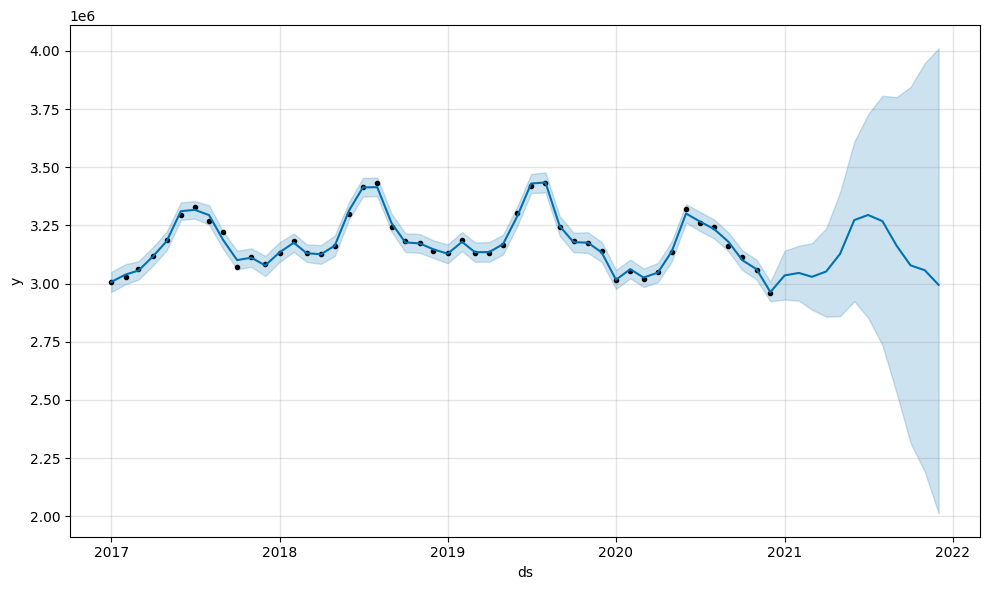

In [20]:
m2 = Prophet(mcmc_samples=300, changepoint_prior_scale=0.8, seasonality_mode='additive', yearly_seasonality=10)
m2.fit(data_train)
future2_1 = m2.make_future_dataframe(periods=len(data_test), freq='MS')
verification2 = m2.predict(future2_1)
MAE_value = MAE(verification2['yhat'][-12:], data_test['y'])
R2_value = R2(verification2['yhat'][-12:], data_test['y'])
RMSE_value = MSE(verification2['yhat'][-12:], data_test['y'])**0.5
Correlation = np.corrcoef(verification2['yhat'][-12:], data_test['y'])[0,1]
print(MAE_value, R2_value, RMSE_value, Correlation)
verif_fig = m2.plot(verification2)
plt.show()

In [21]:
verif_d2 = utils.make_verif(verification2, data_train, data_test)
verif_d2.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,y
ds,,,,,,,,,,,,,,,,,
2021-08-01,2021-08-01,3.110241e+06,2.735541e+06,3.806823e+06,2.569690e+06,3.639081e+06,158257.042306,132825.620242,182590.061023,158257.042306,132825.620242,182590.061023,0.0,0.0,0.0,3.268498e+06,3.399201e+06
2021-09-01,2021-09-01,3.110289e+06,2.529239e+06,3.801618e+06,2.454830e+06,3.757041e+06,52101.968782,26801.425445,79655.771182,52101.968782,26801.425445,79655.771182,0.0,0.0,0.0,3.162391e+06,3.300085e+06
2021-10-01,2021-10-01,3.110335e+06,2.315682e+06,3.845009e+06,2.354968e+06,3.873423e+06,-31698.445896,-72103.846299,5037.894612,-31698.445896,-72103.846299,5037.894612,0.0,0.0,0.0,3.078637e+06,3.254104e+06
2021-11-01,2021-11-01,3.110383e+06,2.191628e+06,3.947978e+06,2.235897e+06,3.996552e+06,-53029.526599,-88234.848075,-16516.086077,-53029.526599,-88234.848075,-16516.086077,0.0,0.0,0.0,3.057354e+06,3.251766e+06
2021-12-01,2021-12-01,3.110429e+06,2.012282e+06,4.010652e+06,2.125608e+06,4.122072e+06,-116042.724085,-143237.631399,-88284.837272,-116042.724085,-143237.631399,-88284.837272,0.0,0.0,0.0,2.994387e+06,3.212158e+06


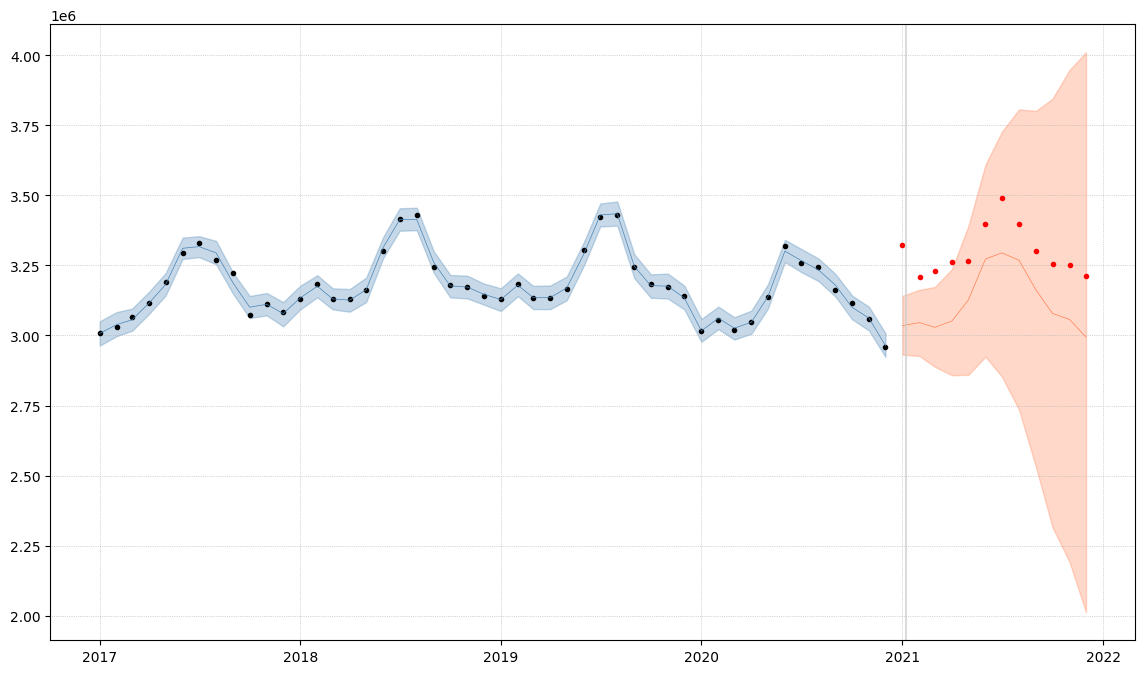

In [22]:
f =  utils.plot_verif(verif_d2)

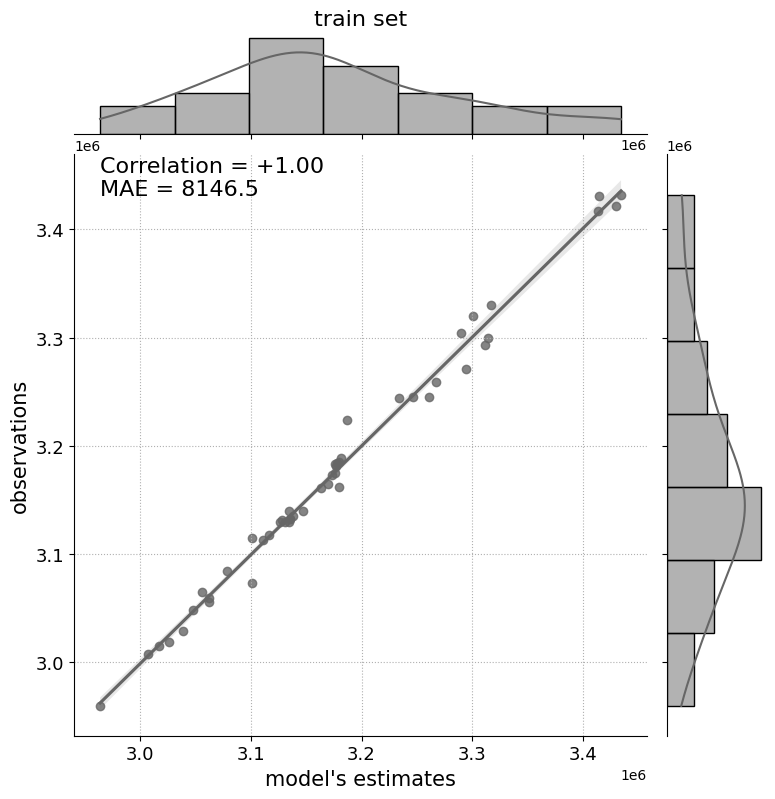

In [23]:
utils.plot_joint_plot(verif_d2.loc[:'2020-12-01',:], title='train set', fname='train_set_joint_plot_climate')

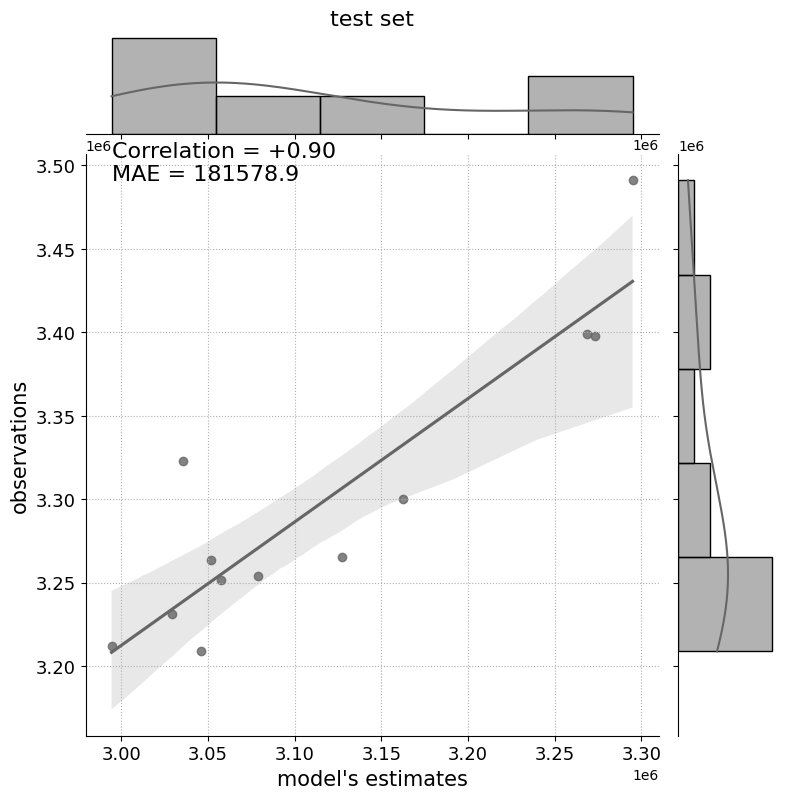

In [24]:
utils.plot_joint_plot(verif_d2.loc['2021-01-01':,:], title='test set', fname='test_set_joint_plot_no_climate')

In [25]:
residuals2 = verif_d2.loc['2021-01-01':,'yhat'] - verif_d2.loc['2021-01-01':,'y']

/tmp/ipykernel_5738/1875567605.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residuals2, ax=ax, color='0.4')


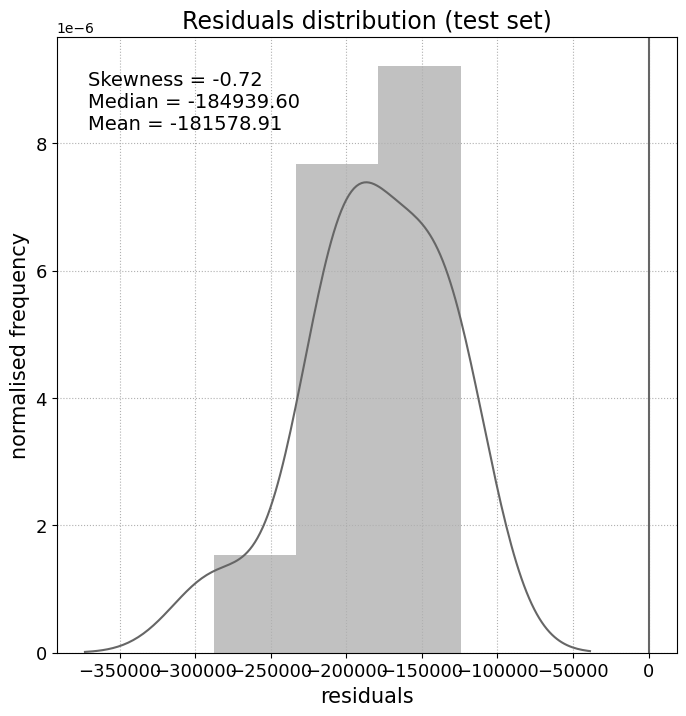

In [26]:
f, ax = plt.subplots(figsize=(8,8))
sns.distplot(residuals2, ax=ax, color='0.4')
ax.grid(ls=':')
ax.set_xlabel('residuals', fontsize=15)
ax.set_ylabel("normalised frequency", fontsize=15)
ax.grid(ls=':')

[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()];

ax.axvline(0, color='0.4')
ax.set_title('Residuals distribution (test set)', fontsize=17)

ax.text(0.05, 0.85, "Skewness = {:+4.2f}\nMedian = {:+4.2f}\nMean = {:+4.2f}".\
        format(skew(residuals2), residuals2.median(), residuals2.mean()), \
        fontsize=14, transform=ax.transAxes)

for ext in ['png','jpeg','pdf']: 
    f.savefig(f'../figures/paper/residuals_distribution_test_set_climate.{ext}', dpi=200)

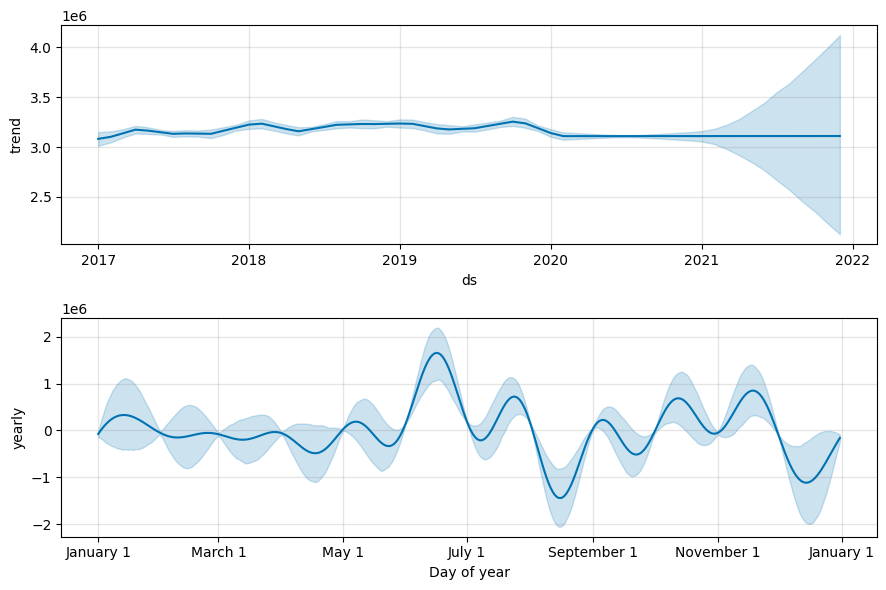

In [27]:
f = m2.plot_components(verification2)

In [29]:
data_future2 = total_data_df.loc["2021-01-01":"2035-01-01"][['y']]
data_future2['ds'] = data_future2.index

(2800000.0, 3700000.0)

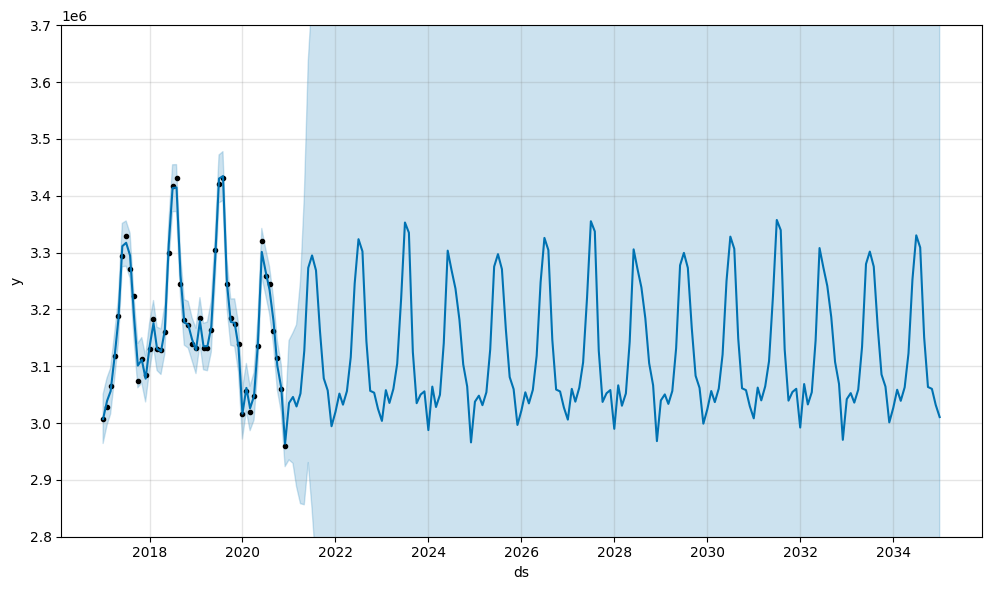

In [31]:
future2_2 = m2.make_future_dataframe(periods=len(data_future2), freq='MS')
forecast2 = m2.predict(future2_2)
forecast_fig_2 = m2.plot(forecast2)
ax = forecast_fig_2.gca()
ax.set_ylim(2800000, 3700000)

### 3.2 Multivariate Analysis for water demand forecast

In [114]:
m3 = Prophet(mcmc_samples=300, changepoint_prior_scale=0.9, seasonality_mode='multiplicative', yearly_seasonality=10)

In [115]:
m3.add_regressor('Rainfall', prior_scale=0.2, mode='multiplicative')
m3.add_regressor('Humidity', prior_scale=0.2, mode='multiplicative')
m3.add_regressor('Temp', prior_scale=0.2, mode='multiplicative')
m3.add_regressor('Total_Population', prior_scale=0.2, mode='multiplicative')
m3.add_regressor('Households', prior_scale=0.2, mode='multiplicative')
m3.add_regressor('Population_per_Households', prior_scale=0.2, mode='multiplicative')

In [116]:
total_data_df['ds'] = total_data_df.index
data_train = total_data_df[['ds', 'y', 'Rainfall', 'Humidity', 'Temp', 'Total_Population', 'Households', 'Population_per_Households']].loc["2017-01-01":"2020-12-01"]
data_test = total_data_df[['ds', 'y', 'Rainfall', 'Humidity', 'Temp', 'Total_Population', 'Households', 'Population_per_Households']].loc["2021-01-01":"2021-12-01"]

/tmp/ipykernel_5738/339961374.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data_df['ds'] = total_data_df.index


In [117]:
m3.fit(data_train)

06:22:16 - cmdstanpy - INFO - CmdStan installation /opt/conda/envs/water_forecast/lib/python3.9/site-packages/prophet/stan_model/cmdstan-2.26.1 missing makefile, cannot get version.
06:22:16 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
06:22:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

06:22:24 - cmdstanpy - INFO - CmdStan done processing.
06:22:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in '/project/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
06:22:24 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 150 iterations at max treedepth (100.0%)
	Chain 2 had 150 iterations at max treedepth (100.0%)
	Chain 3 had 150 iterations at max treedepth (100.0%)
	Chain 4 had 150 iterations at max treedepth (100.0%)
	Use function "diagnose()"

In [118]:
future3_1 = m3.make_future_dataframe(periods=len(data_test), freq='MS')

In [119]:
futures3_1 = utils.add_regressor_to_future(future3_1, [total_data_df['Rainfall'], total_data_df['Humidity'], total_data_df['Temp'],
                                         total_data_df['Total_Population'], total_data_df['Households'], total_data_df['Population_per_Households']])

In [120]:
futures3_1

,ds,Rainfall,Humidity,Temp,Total_Population,Households,Population_per_Households
0,2017-01-01,14.9,55.0,-1.8,9930478.0,4192985.0,2.368355
1,2017-02-01,11.1,54.0,-0.2,9931412.0,4200761.0,2.364194
2,2017-03-01,7.9,48.0,6.3,9926968.0,4202888.0,2.361940
3,2017-04-01,61.6,52.0,13.9,9922745.0,4203957.0,2.360335
4,2017-05-01,16.1,52.0,19.5,9919016.0,4207393.0,2.357521
5,2017-06-01,66.6,57.0,23.3,9914381.0,4210933.0,2.354438
6,2017-07-01,621.0,77.0,26.9,9908612.0,4213667.0,2.351541
7,2017-08-01,297.0,71.0,25.9,9902072.0,4217954.0,2.347601
8,2017-09-01,35.0,61.0,22.1,9891448.0,4219001.0,2.344500
9,2017-10-01,26.5,56.0,16.4,9882810.0,4219562.0,2.342141


82312.64025947517 0.19032318823505268 103552.5651354685 0.8461935425202968


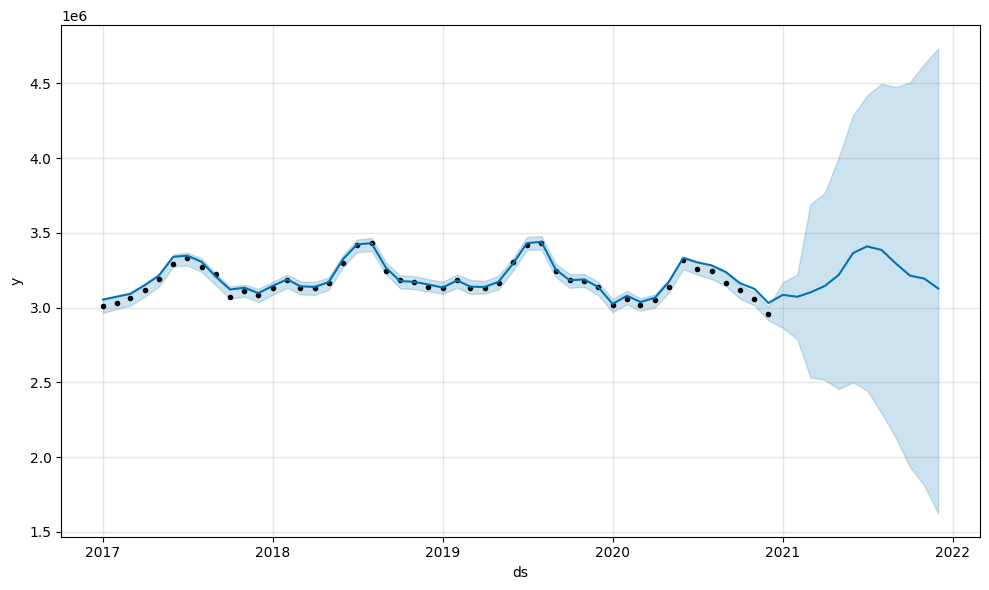

In [121]:
verification3 = m3.predict(futures3_1)
MAE_value = MAE(verification3['yhat'][-12:], data_test['y'])
R2_value = R2(verification3['yhat'][-12:], data_test['y'])
RMSE_value = MSE(verification3['yhat'][-12:], data_test['y'])**0.5
Correlation = np.corrcoef(verification3['yhat'][-12:], data_test['y'])[0,1]
print(MAE_value, R2_value, RMSE_value, Correlation)
verif_fig = m3.plot(verification3)
plt.show()

In [122]:
verif_d3 = utils.make_verif(verification3, data_train, data_test)
verif_d3.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Households,Households_lower,Households_upper,Humidity,...,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat,y
ds,,,,,,,,,,,,,,,,,,,,,
2021-08-01,2021-08-01,3.005769e+06,2.295997e+06,4.496549e+06,2.007998e+06,4.328514e+06,0.017065,-0.315407,0.357240,-0.003908,...,-0.116636,0.361014,0.046556,0.009246,0.081248,0.0,0.0,0.0,3.385454e+06,3.399201e+06
2021-09-01,2021-09-01,3.000702e+06,2.129302e+06,4.474204e+06,1.920037e+06,4.461704e+06,0.017628,-0.325822,0.369036,-0.003133,...,-0.148466,0.337716,0.018332,-0.004522,0.039819,0.0,0.0,0.0,3.294837e+06,3.300085e+06
2021-10-01,2021-10-01,2.995798e+06,1.936163e+06,4.505273e+06,1.807556e+06,4.598147e+06,0.017816,-0.329298,0.372972,-0.002875,...,-0.176672,0.318497,-0.003956,-0.019732,0.010217,0.0,0.0,0.0,3.213820e+06,3.254104e+06
2021-11-01,2021-11-01,2.990731e+06,1.810727e+06,4.629054e+06,1.676025e+06,4.714961e+06,0.018029,-0.333233,0.377430,-0.002358,...,-0.183910,0.318961,-0.007029,-0.037171,0.020462,0.0,0.0,0.0,3.193790e+06,3.251766e+06
2021-12-01,2021-12-01,2.985827e+06,1.623349e+06,4.732857e+06,1.519643e+06,4.866256e+06,0.018262,-0.337530,0.382296,-0.000807,...,-0.212000,0.299236,-0.026019,-0.070811,0.017070,0.0,0.0,0.0,3.127401e+06,3.212158e+06


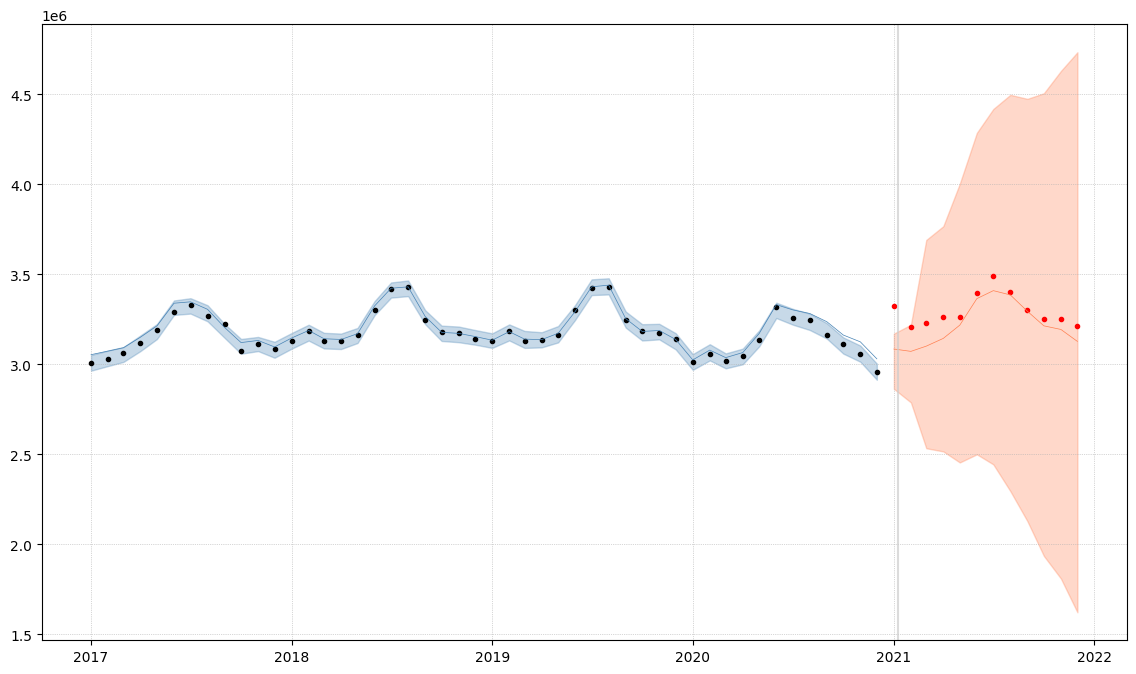

In [123]:
f =  utils.plot_verif(verif_d3)

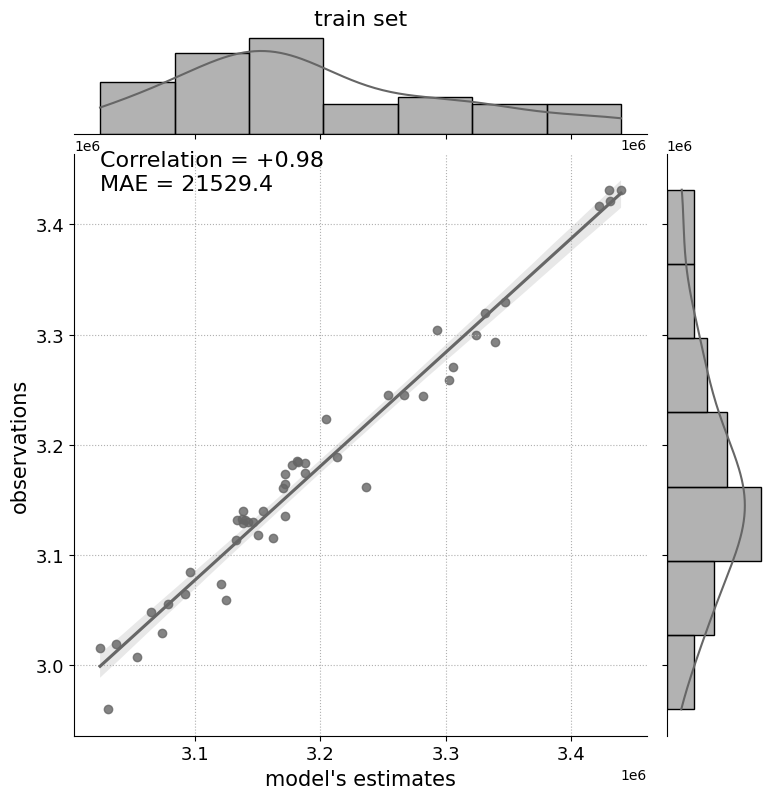

In [124]:
utils.plot_joint_plot(verif_d3.loc[:'2020-12-01',:], title='train set', fname='train_set_joint_plot_climate')

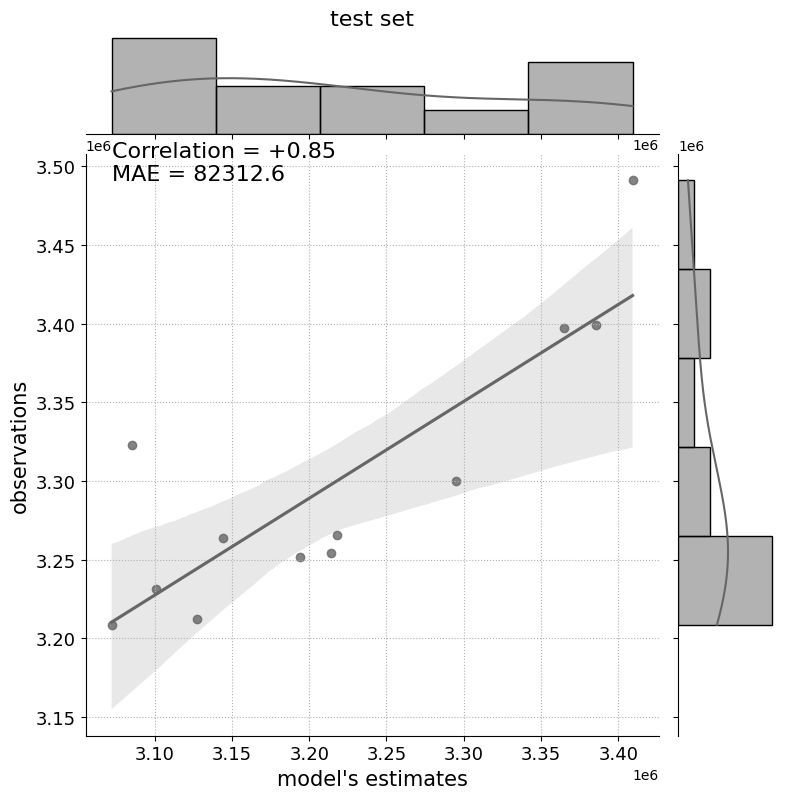

In [125]:
utils.plot_joint_plot(verif_d3.loc['2021-01-01':,:], title='test set', fname='test_set_joint_plot_no_climate')

In [126]:
residuals3 = verif_d3.loc['2021-01-01':,'yhat'] - verif_d3.loc['2021-01-01':,'y']

/tmp/ipykernel_5738/2718652374.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residuals3, ax=ax, color='0.4')


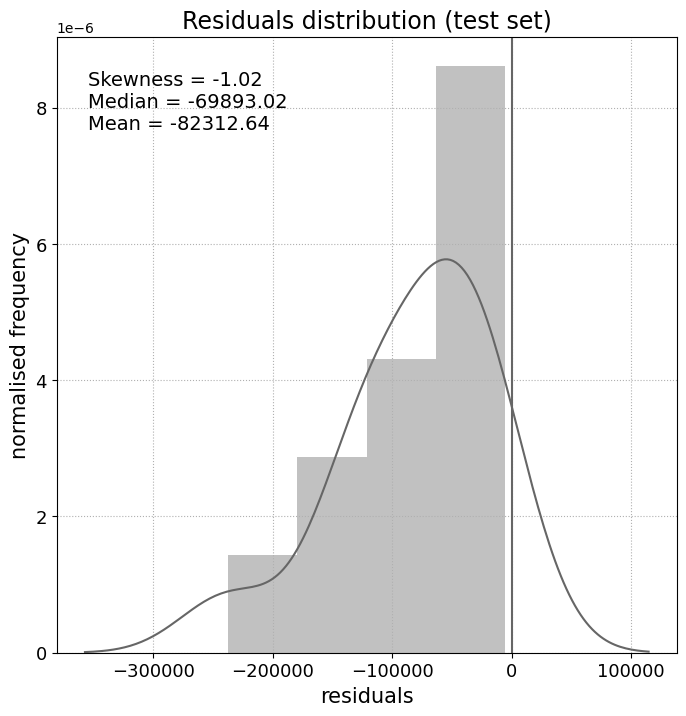

In [127]:
f, ax = plt.subplots(figsize=(8,8))
sns.distplot(residuals3, ax=ax, color='0.4')
ax.grid(ls=':')
ax.set_xlabel('residuals', fontsize=15)
ax.set_ylabel("normalised frequency", fontsize=15)
ax.grid(ls=':')

[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()];

ax.axvline(0, color='0.4')
ax.set_title('Residuals distribution (test set)', fontsize=17)

ax.text(0.05, 0.85, "Skewness = {:+4.2f}\nMedian = {:+4.2f}\nMean = {:+4.2f}".\
        format(skew(residuals3), residuals3.median(), residuals3.mean()), \
        fontsize=14, transform=ax.transAxes)

for ext in ['png','jpeg','pdf']: 
    f.savefig(f'../figures/paper/residuals_distribution_test_set_climate.{ext}', dpi=200)

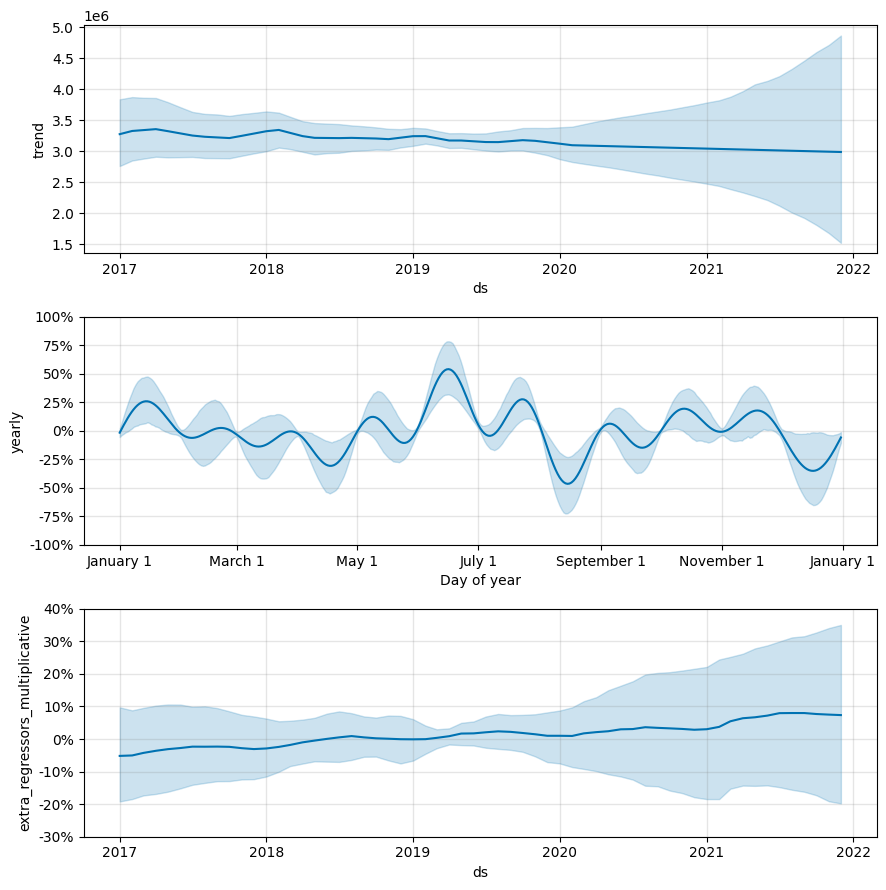

In [128]:
f = m3.plot_components(verification3)

In [129]:
data_future3 = total_data_df[['ds', 'y', 'Rainfall', 'Humidity', 'Temp', 'Total_Population', 'Households', 'Population_per_Households']].loc["2021-01-01":"2035-01-01"]
data_future3

,ds,y,Rainfall,Humidity,Temp,Total_Population,Households,Population_per_Households
date,,,,,,,,
2021-01-01,2021-01-01,3.322616e+06,18.900000,58.000000,-2.400000,9657969.0,4421022.0,2.184556
2021-02-01,2021-02-01,3.208704e+06,7.100000,56.000000,2.700000,9648606.0,4427814.0,2.179090
2021-03-01,2021-03-01,3.231347e+06,110.900000,63.000000,9.000000,9598484.0,4400403.0,2.181274
2021-04-01,2021-04-01,3.263708e+06,124.100000,54.000000,14.200000,9588711.0,4403263.0,2.177638
2021-05-01,2021-05-01,3.265422e+06,183.100000,68.000000,17.100000,9575355.0,4403381.0,2.174546
...,...,...,...,...,...,...,...,...
2034-09-01,2034-09-01,NaN,17.473418,0.639263,23.841022,8994658.0,3888453.0,2.313171
2034-10-01,2034-10-01,NaN,21.209567,0.560021,16.753755,8994658.0,3888453.0,2.313171
2034-11-01,2034-11-01,NaN,19.714946,0.561118,11.048479,8994658.0,3888453.0,2.313171


In [130]:
future3_2 = m3.make_future_dataframe(periods=len(data_future3), freq='MS')

In [131]:
future3_2

,ds
0,2017-01-01
1,2017-02-01
2,2017-03-01
3,2017-04-01
4,2017-05-01
...,...
212,2034-09-01
213,2034-10-01
214,2034-11-01
215,2034-12-01


In [132]:
futures3_2 = utils.add_regressor_to_future(future3_2, [total_data_df['Rainfall'], total_data_df['Humidity'], total_data_df['Temp'],
                                                     total_data_df['Total_Population'], total_data_df['Households'], total_data_df['Population_per_Households']])

In [133]:
futures3_2

,ds,Rainfall,Humidity,Temp,Total_Population,Households,Population_per_Households
0,2017-01-01,14.900000,55.000000,-1.800000,9930478.0,4192985.0,2.368355
1,2017-02-01,11.100000,54.000000,-0.200000,9931412.0,4200761.0,2.364194
2,2017-03-01,7.900000,48.000000,6.300000,9926968.0,4202888.0,2.361940
3,2017-04-01,61.600000,52.000000,13.900000,9922745.0,4203957.0,2.360335
4,2017-05-01,16.100000,52.000000,19.500000,9919016.0,4207393.0,2.357521
...,...,...,...,...,...,...,...
212,2034-09-01,17.473418,0.639263,23.841022,8994658.0,3888453.0,2.313171
213,2034-10-01,21.209567,0.560021,16.753755,8994658.0,3888453.0,2.313171
214,2034-11-01,19.714946,0.561118,11.048479,8994658.0,3888453.0,2.313171
215,2034-12-01,23.977293,0.531725,1.255939,8994658.0,3888453.0,2.313171


In [134]:
forecast3 = m3.predict(futures3_2)

(2800000.0, 4200000.0)

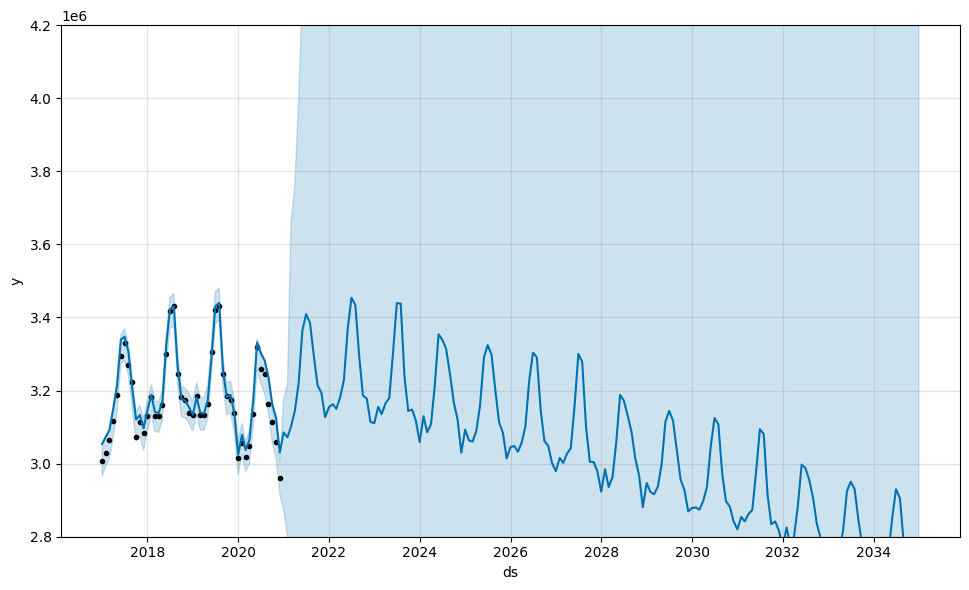

In [135]:
forecast_fig_3 = m3.plot(forecast3)
ax = forecast_fig_3.gca()
ax.set_ylim(2800000, 4200000)